# Lesson 1 - What's your pet

[ source: https://course.fast.ai/videos/?lesson=1 ]

Lesson 1: Image classification

You can click the blue arrow buttons on the left and right panes to hide them and make more room for the video. You can search the transcript using the text box at the bottom. Scroll down this page for links to many useful resources. If you have any other suggestions for links, edits, or anything else, you'll find an "edit" link at the bottom of this (and every) notes panel.
Overview

To follow along with the lessons, you'll need to connect to a cloud GPU provider which has the fastai library installed (recommended; it should take only 5 minutes or so, and cost under $0.50/hour), or set up a computer with a suitable GPU yourself (which can take days to get working if you're not familiar with the process, so we don't recommend it). You'll also need to be familiar with the basics of the Jupyter Notebook environment we use for running deep learning experiments. Up to date tutorials and recommendations for these are available from the course website.

The key outcome of this lesson is that we'll have trained an image classifier which can recognize pet breeds at state of the art accuracy. The key to this success is the use of transfer learning, which will be a key platform for much of this course. We'll also see how to analyze the model to understand its failure modes. In this case, we'll see that the places where the model is making mistakes is in the same areas that even breeding experts can make mistakes.

We'll discuss the overall approach of the course, which is somewhat unusual in being top-down rather than bottom-up. So rather than starting with theory, and only getting to practical applications later, instead we start with practical applications, and then gradually dig deeper and deeper in to them, learning the theory as needed. This approach takes more work for teachers to develop, but it's been shown to help students a lot, for example in education research at Harvard by David Perkins.

We also discuss how to set the most important hyper-parameter when training neural networks: the learning rate, using Leslie Smith's fantastic learning rate finder method. Finally, we'll look at the important but rarely discussed topic of labeling, and learn about some of the features that fastai provides for allowing you to easily add labels to your images.

If you want to more deeply understand how PyTorch really works, you may want to check out this official PyTorch tutorial by Jeremy—although we'd only suggest doing that once you've completed a few lessons.
Links
Lesson resources

    Course site, including setup guides for each platform
    Course repo
    fastai docs
    fastai datasets
    Notebooks:
        00_notebook_tutorial.ipynb
        lesson1-pets.ipynb
    Detailed lesson notes - thanks to @hiromi
    Lesson notes - thanks to @PoonamV (wiki thread - please help contribute!)
    Lesson discussion thread

Other resources

    Thread on creating your own image dataset
    What you need to do deep learning (fast.ai blog post including some basics on what GPUs are and why they're needed)
    Original Paper for Oxford-IIIT Pet Dataset
    The Oxford-IIIT Pet Dataset
    What the Regular Expressions in the notebook meant
    Understanding Regular Expressions (12 minute video)
    Visualize Regular Expressions
    Interactive tutorial to learn Regular Expressions
    Beginners Tutorial of Regular Expression
    One-Cycle Policy Fitting paper
    Visualizing and Understanding Convolutional Networks (paper)
    Splunk and Tensorflow for Security
    Learning Rate Finder Paper

How to scrape images

    Official course tutorial
    https://forums.fast.ai/t/tips-for-building-large-image-datasets/26688
    https://forums.fast.ai/t/generating-image-datasets-quickly/19079
    https://forums.fast.ai/t/how-to-scrape-the-web-for-images/7446/8

Suggested Practice

Create a model that can correctly classify images. Use lesson2-download.ipynb (available here in the course repo) as a means of guidance. Remember, the more you practice the better you will get!
Edit this page

To edit this page, click here. This will take you to a edit window at GitHub where you can submit your suggested changes. They will automatically be turned in to a pull request which will be reviewed by an admin prior to publication.

---

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
# some magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

- more: https://docs.fast.ai/

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# "import *" not really suggested elsewhere, but the sense here is to make
# it like matlab, e.g. all available at any time.

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
# local: it will write dataset into /Users/bonacor/.fastai/data/oxford-iiit-pet
# colab: you will see "Downloading https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet"

path = untar_data(URLs.PETS); path

PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/annotations')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),
 PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),
 PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),
 PosixPath('/Users/bonacor/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'  # the regex pattern

In [10]:
# re = regex. This is the fast.ai way to extract labels from images if they are in the filenames, actually

# size: a GPU has to apply the exact same instruction to a large set of SAME stuff to be efficient,
# so we try to have same size for everyone. 224 is very used., it generally works for most things most of the time

data = ImageDataBunch.from_name_re(path_img,
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(),
                                   size=224,
                                   bs=bs,
                                   num_workers=0                # (1)
                                  ).normalize(imagenet_stats)

# (1) if you do NOT add this one, it will fail next cell. See https://forums.fast.ai/t/dataloader-error/36405/3

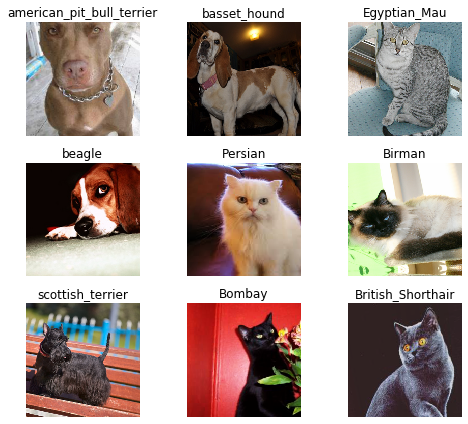

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes) 

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


37

A databunch will always have a property called .c. Think of it as the nb of classes (for multilabel classification this is not accurate, as we will see later).

In [13]:
data.c

37

## Training: resnet34

Some jargon. Roughly speaking:

- a dataset is a DATABUNCH in fastai
- a model is a LEARNER in fastai

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

NOTE: 
- data is a databunch
- resnet34 works well in most cases. Start with it and eventually use a larger one


In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# error_rate is on a validation set, created automatically..

What has it downloaded?! resnet34 pretrained weights. This model has already been trained, on 1.5M pictures of all types of different things. So we should not start from a model that knows nothing but start from a model that already has been tuned to distinguish thousands of categories of basic things/objects/animals. Note that here we have 37 categories of dogs and cats: probably the pretrained weights will not come from training over those precise categories, but the trainbing phase had SOME dogs and SOME cats, and learnt something alredy about their differences. Definitely it is able to distinguish animals vs not animals w.r.t a random start! This is an example of **transfer learning**.

In [15]:
learn.fit_one_cycle(4)
# very recent development!
# we will learn later on how to tune this nb

epoch,train_loss,valid_loss,error_rate,time
0,1.387822,0.347325,0.102165,36:43


KeyboardInterrupt: 

The output (e.g. from colab, where it is quicker) might be something like:

    epoch	train_loss	valid_loss	error_rate	time
    0	1.386591	0.312454	0.098782	02:05
    1	0.555678	0.230857	0.078484	02:03
    2	0.345028	0.197526	0.071042	02:02
    3	0.249380	0.189279	0.065629	02:03

6% !!!

In [ ]:
learn.model

In [ ]:
learn.save('stage-1')
# it will write it down in a subdir of the dir where your input data resides.

Check the 2012 paper: at that time, they got an accuracy of 59%. Today, we get 94%. As easy as this.

## Results

We examined what went in, and trained it, now let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

You pass a `learn` object, that contains 2 things: the data and the (trained) model. And it is all we need to interpret what we did. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

Check what are the things you were most wrong with.

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

Below, how to check not the quick `help` but the real fastai `doc` with all you might need. There will be a "Shown in docs" button that will bring you to the proper docs.fast.ai page. Also, `[source]` links from there do exist, and jumps you directly to the fastai code, so you can check what it does!

In [16]:
# doc(interp.plot_top_losses)

# it appears it does not exist in the docs (yet?)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The former is the usual way. The latter is the crazily clever fastai way. It will grab, out of the confusion matrix, the actual?predicted combinations that got wrong most often.

( you should see something like: )

In [18]:
from IPython.display import Image
Image("images/confusiomatrix.png")

FileNotFoundError: No such file or directory: 'images/confusiomatrix.png'

FileNotFoundError: No such file or directory: 'images/confusiomatrix.png'

<IPython.core.display.Image object>

In [19]:
interp.most_confused(min_val=2)

NameError: name 'interp' is not defined

## Unfreezing, fine-tuning, and learning rates

CNN is done in layers. We imported a pretrained one, added few layers at the end and we just trained them (this was done in the fit_one_cycle part): it was quick. But we basically left most of the model as it was (think of this in terms of the value of the weights). If we are OK with a model that - to large extent - is much like the ImageNet one we imported as a pretrained model, we are fine as we are and we need to do nothing more. BUT, if we want to diverge a bit, specialize a bit, we need to fine tune now. And this is the ONLY way in which we can improve further.

Since our model is working as we expect it to, it is now timew to *unfreeze* our model and train some more. Actually, train the whole model.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

This gives:

    epoch	train_loss	valid_loss	error_rate	time
    0	0.511821	0.373484	0.112314	02:13


Notice that it gets much worse, from 6% to 11%! (NOTE: nbs might vary). We need to understand why. Read the paper "VIsualizing and understanding convolutional networks" by Zeiler and Fergus. 

Check Layer 1. This is a very very simple first layer.  The involved compitation is a "convolution". The fig displays all coefficients, all the parameters in layer 1. You see the part that operates on groups of pixel next to each other ina  direction, then in another, this finds gradients from orange to blue or from yellow to bluw, in different directions, etc. So, **a first layer can find e.g. very simple LINES**.

CHeck Layer 2. It starts to find e.g. corners, round shapes, etc. Meaning it combined the knowledge from previous layer into a subsequent layer where it goes deeper in understanding: I found lines first, before being able to find two orthogonal lines, etc. There is also a pic of the actual part of the images that triggered what we see in Layer 2, which is self/explanatory. So, **a second layer can find e.g. very simple SHAPES**.

Check Layer 3. **A third layer can find a combination of LINES and SHAPES**. We can find repeating patterns of 2D objects. Or patterns that join together. Of course there are "mistakes", take e,g, the example of what activated what in the fig: windows or bar code or text activate the same way!

Check Layer 4. **A fourth layer can find e.g. birds legs, or animal eyes, or dog faces, etc**.

Check Layer 5. **A fifth layer can find e.g. animal eyes with no major mistakes, still might be confused between dog and human faces and car wheels, for example..**. I.e. need few more layers to disentangle them!

Check layer 34 (resnet34). **It identifies dog with no mistakes and is already able to disentangle specific dog and cat breeds**. Just needed some more layers. That's it.


What we did when we imported a pretrained model, is that we fine-tuned that pre-trained model by training just a few additional layers on top, to handle sophisticated features. 

What if we want to improve now?

It is VERY unlikely that if we re-train from Level-1, we will do better at that level. Indeed, how can it be that the definition of a diagonal, for example, is different when we are training ImageNet or a dataset of dogs and cats only.. we do NOT want to change the **first layer** at all. On the other hand, the **last layers** is something I definitely want to improve: check e.g. layer 5, where we see the NN has the ability to group dogs and cats and distinguish them from the rest of images, but it still confuses dogs and cats w.r.t themselves.. this is not enough for us, as we need more sophistication than that, we need to distinguish them also by breeds!

In this sense we understand that different layer of a NN represemnts different levels of semantic complexity. 

So far we have by default trained all layers at the same speed. We need to fine tune what we did. We reload it and fine tune.

Then, find the best **learning rate** automatically:

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

It takes a bit, then it suggests you the following:

    LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

Indeed, you can easily make a plot of the loss (y aaxis) vs different values of the l.r.:

In [ ]:
learn.recorder.plot()

Now, you could just pick a value, but suggestion from fast.ai developers is to fit again by giving a range of values for lr. Namely, if the suggested value is around 1e-3, go 1 order of magnitude lower, and set that as a max, and 2 orders of magnitude even less and aset that as a min. This is just a trick/suggestion from devs.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

(NOTE: you should be getting some 10ish% relative improvement wrt before. It is fine-tuning so you should not expect so much than that! And at the cost of a dozens of secs of training on a good GPU..)

That's a pretty accurate model!

NOTE: these 2 stages are mostly OK for most world-w ide use-cases. But, people want to win kaggle challenges :) so this is not sufficient.

## Training: resnet50

If you run this blindly, you will get an error, i.e. GPU running out of memory. Resnet50 is bigger, therefore it has more parameters, and therefore needs more mem. It will try to make too many parameters' update at the same time and would need more mem than it actually has. E.g. a default AWS resource, less than 16 GB of GPU mem will give you frustrating times. 

    Hint: bs is the nb images you train at one time..
    bs=48 works on a 11GB card, if you have an 8GB make it bs=32, etc.. with a 16Gb card, go for bs=64. Thumb rule: 4x the GB of RAM you have.. check on colab and exercise! it is fine to reduce bs, it will just take a bit longer..

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

And you become a domain expert :)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

The MNIST dataset looks like this:

In [ ]:
path.ls()

In `/train`, there is a folder with 3s and a folder with 7s.

In [ ]:
(path/'train').ls()

In these situation, you can call `ImageDataBunch.from_folder`:

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
doc(ImageDataBunch.from_folder)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Another possibility to read the dataset in, is to read the csv file, as follows (labels 0/1 map to being a 3 or a 7):

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In this case you use `ImageDataBunch.from_csv`:

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
doc(ImageDataBunch.from_df)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
doc(ImageDataBunch.from_df)

Another possibility is to imprt dataset by different files on a path, using a regex:

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
doc(ImageDataBunch.from_name_re)

You can create an arbitrary function that extract the label from the filename or path, and use `ImageDataBunch.from_name_func`.

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
doc(ImageDataBunch.from_name_func)

Another possibility is that you created an array with labels, and then you pass it as a list using `ImageDataBunch.from_lists`:

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

In [ ]:
doc(ImageDataBunch.from_lists)

But where do I find this kind of info, i.e. that I can do `ImageDataBunch.from_lists`, or `ImageDataBunch.from_name_func`, etc?

NOTE: every single line we used so far appears as is in the official fast.ai documentation. And you can read/learn more about each with `doc()` and clicking on `Show in docs`. In addition, **all documentation is actually code, and in Jupyter notebooks**. 

For example, suppose I want to know more about `ImageDataBunch.from_name_re`:

- type in a Jupyter cell `doc(ImageDataBunch.from_name_re` and execute it
- click on `Show in docs` and read the page
- you can do more, e.g. https://github.com/fastai/fastai/tree/master/docs_src where you see docs as ipynb files. E.g. in the previous case, read the page URL (e.g. https://docs.fast.ai/vision.data.html#ImageDataBunch.from_name_re) and check for `vision.data` into the `docs_src` page to get its ipynb source.

In [22]:
doc(ImageDataBunch.from_name_re)